In [1]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data import TimeSeriesData
from transform import make_tabular_ts
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [2]:
ts = TimeSeriesData()
df = ts.get_data()

col = "LPG"

data = df.loc[:, col]
train = data.loc[:len(data) * 0.6].dropna()
test = data.loc[int(len(data) * 0.6):].dropna()

train_data = make_tabular_ts(train.tolist())
test_data = make_tabular_ts(test.tolist())

X_train, y_train = train_data[:, :-1].astype(np.float32), train_data[:, -1].flatten().astype(np.float32)
X_test, y_test = test_data[:, :-1].astype(np.float32), test_data[:, -1].flatten().astype(np.float32)

X_train = X_train.reshape(-1, 4, 1)
X_test = X_test.reshape(-1, 4, 1)

lstm = Sequential()
lstm.add(LSTM(32, activation="relu", return_sequences=True))
lstm.add(LSTM(1, activation=None))

lstm.compile(loss="mse", optimizer="adam", metrics=["mse"])
lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2022-12-01 21:40:10.119431: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


150/150 [==============================] - 3s 6ms/step - loss: 21.9447 - mse: 21.9447 - val_loss: 0.3439 - val_mse: 0.3439
Epoch 2/10
150/150 [==============================] - 1s 4ms/step - loss: 0.6747 - mse: 0.6747 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 3/10
150/150 [==============================] - 1s 4ms/step - loss: 0.5472 - mse: 0.5472 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 4/10
150/150 [==============================] - 1s 4ms/step - loss: 0.4840 - mse: 0.4840 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 5/10
150/150 [==============================] - 1s 4ms/step - loss: 0.4499 - mse: 0.4499 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 6/10
150/150 [==============================] - 1s 4ms/step - loss: 0.4399 - mse: 0.4399 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 7/10
150/150 [==============================] - 1s 4ms/step - loss: 0.4262 - mse: 0.4262 - val_loss: 0.0677 - val_mse: 0.0677
Epoch 8/10
150/150 [==============================] - 1s 4ms/step - loss: 0.4173 - ms

In [3]:
lstm.evaluate(X_test, y_test)

100/100 [==============================] - 0s 1ms/step - loss: 0.0659 - mse: 0.0659


[0.0659157782793045, 0.0659157782793045]

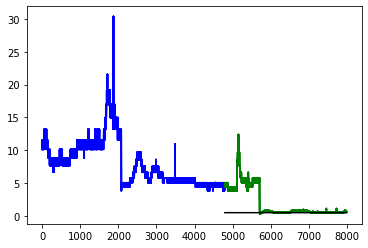

In [20]:
init_data = X_train[-1]
predicted = []
for i in range(len(test_data)):
    prediction = lstm.predict(np.expand_dims(init_data, axis=0))
    predicted.append(prediction[0])
    init_data[:-1] = init_data[1:]
    init_data[-1] = prediction

plt.plot(np.arange(len(train_data)), train_data, color='b')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, color='g')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), predicted, color='black')

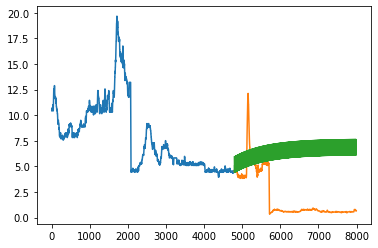

In [32]:
from sklearn.linear_model import LinearRegression

rolling_mean = df.loc[:, col].rolling(window=10).mean().dropna()
train = rolling_mean.iloc[:int(len(rolling_mean) * 0.6)]
test = rolling_mean.iloc[int(len(rolling_mean) * 0.6):]
train_data = make_tabular_ts(train.tolist())
test_data = make_tabular_ts(test.tolist())

X_train, y_train = train_data[:, :-1], train_data[:, -1].flatten()

model = LinearRegression()
model.fit(X_train, y_train)
    
init_mean_data = X_train[-1]
index = len(train)
init_data = df.loc[:, col].iloc[index:index + 10].astype(float).tolist()
init_data[-1] = 0 # we haven't known this value yet
predicted_values = []
    
for _ in range(len(test)):
    new_data = model.predict([init_mean_data])
    actual_value = 10 * new_data[0] - sum(init_data[:-1])
    predicted_values.append(actual_value)
    init_data[-1] = actual_value
    init_data = init_data[1:]
    init_data.append(0)
    init_mean_data[:-1] = init_mean_data[1:]
    init_mean_data[-1] = float(new_data[0])
plt.plot(np.arange(len(train)), train)
plt.plot(np.arange(len(train), len(train) + len(test)), test)
plt.plot(np.arange(len(train), len(train) + len(test)), predicted_values)